In [83]:
# Importing Libraries
import tensorflow as tf
import os
import numpy as np
import sys
import random
import cv2
import glob
import matplotlib.pyplot as plt
import xlrd
import tensorflow.keras.backend as K
import time

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from dataset.bdd100k_seg.labels import *
from PIL import Image

In [84]:
seed = 42
np.random.seed = seed

In [85]:
# Storing labels in dicionary
labelID = {}
rgbColorID = {}

for index,label in enumerate(labels):
    labelID[index] = label.name
    rgbColorID[index] = label.color

print(labelID)
print(rgbColorID)

{0: 'unlabeled', 1: 'dynamic', 2: 'ego vehicle', 3: 'ground', 4: 'static', 5: 'parking', 6: 'rail track', 7: 'road', 8: 'sidewalk', 9: 'bridge', 10: 'building', 11: 'fence', 12: 'garage', 13: 'guard rail', 14: 'tunnel', 15: 'wall', 16: 'banner', 17: 'billboard', 18: 'lane divider', 19: 'parking sign', 20: 'pole', 21: 'polegroup', 22: 'street light', 23: 'traffic cone', 24: 'traffic device', 25: 'traffic light', 26: 'traffic sign', 27: 'traffic sign frame', 28: 'terrain', 29: 'vegetation', 30: 'sky', 31: 'person', 32: 'rider', 33: 'bicycle', 34: 'bus', 35: 'car', 36: 'caravan', 37: 'motorcycle', 38: 'trailer', 39: 'train', 40: 'truck'}
{0: (0, 0, 0), 1: (111, 74, 0), 2: (0, 0, 0), 3: (81, 0, 81), 4: (0, 0, 0), 5: (250, 170, 160), 6: (230, 150, 140), 7: (128, 64, 128), 8: (244, 35, 232), 9: (150, 100, 100), 10: (70, 70, 70), 11: (190, 153, 153), 12: (180, 100, 180), 13: (180, 165, 180), 14: (150, 120, 90), 15: (102, 102, 156), 16: (250, 170, 100), 17: (220, 220, 250), 18: (255, 165, 0), 

In [86]:
def rgb_to_onehot(rgb_image, colormap):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
#     print(num_classes)
    shape = rgb_image.shape[:2]+(num_classes,)
#     print(type(shape))
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image

In [87]:
trainingImagesNames = []
trainingMasksNames = []

for filename in glob.glob('dataset/bdd100k_seg/images/train/*.jpg'):
    trainingImagesNames.append(filename)

for filename in glob.glob('dataset/bdd100k_seg/color_labels/train/*.png'):
    trainingMasksNames.append(filename)


In [88]:
validationImagesNames = []
validationMasksNames = []

for filename in glob.glob('dataset/bdd100k_seg/images/val/*.jpg'):
    validationImagesNames.append(filename)

for filename in glob.glob('dataset/bdd100k_seg/color_labels/val/*.png'):
    validationMasksNames.append(filename)


In [202]:
# Defining Hyperparameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
numClasses = 41
batchSize = 1
learningRate = 0.01
stepsPerEpoch = len(trainingImagesNames)//batchSize
numOfEpoch = 100
validationSteps = len(validationImagesNames)//batchSize

In [203]:
class My_Generator(tf.keras.utils.Sequence):

    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X_train = []
        Y_train = []
        
        for image in batch_x:
            train = cv2.imread(image)
            train = cv2.resize(train, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
            X_train.append(train)

        for image in batch_y:
            Mask = Image.open(image).convert('RGB')
            Mask = np.asarray(Mask)
            Mask = cv2.resize(Mask, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
            Mask = rgb_to_onehot(Mask, rgbColorID)
            Y_train.append(Mask)
            
        return (np.array(X_train, dtype='uint8'), np.array(Y_train, dtype='uint8'))


In [204]:
# Building the U-net model
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)) # Defining the input layer
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs) # Converting input pixels to floating values

c1 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1) # To prevent neural net from over fitting
c1 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2) # To prevent neural net from over fitting
c2 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3) # To prevent neural net from over fitting
c3 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4) # To prevent neural net from over fitting
c4 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5) # To prevent neural net from over fitting
c5 = tf.keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
# p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

# c6 = tf.keras.layers.Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
# c6 = tf.keras.layers.Dropout(0.3)(c6) # To prevent neural net from over fitting
# c6 = tf.keras.layers.Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# Decoding the layers
# u7 = tf.keras.layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c6)
# u7 = tf.keras.layers.concatenate([u7, c5])
# c7 = tf.keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
# c7 = tf.keras.layers.Dropout(0.2)(c7) # To prevent neural net from over fitting
# c7 = tf.keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c5)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8) # To prevent neural net from over fitting
c8 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9) # To prevent neural net from over fitting
c9 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

u10 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Dropout(0.1)(c10) # To prevent neural net from over fitting
c10 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

u11 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1], axis=3)
c11 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Dropout(0.1)(c11) # To prevent neural net from over fitting
c11 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

outputs = tf.keras.layers.Conv2D(41, (1,1), activation='softmax', padding='same')(c11)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= tf.keras.optimizers.Adadelta(learning_rate=learningRate), loss='categorical_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=numClasses)])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 512, 512, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 512, 512, 32) 896         lambda_9[0][0]                   
__________________________________________________________________________________________________
dropout_81 (Dropout)            (None, 512, 512, 32) 0           conv2d_171[0][0]                 
____________________________________________________________________________________________

In [205]:
# Model Checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_multiclass.h5',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  monitor='mean_io_u_9',
                                                  mode='max')

callbacks = [
             tf.keras.callbacks.EarlyStopping(patience=1,
                                              monitor='mean_io_u_9',
                                              mode='max'),
             tf.keras.callbacks.TensorBoard(log_dir='logs',
                                            write_graph=True)]

In [206]:
trainingDataGenerator = My_Generator(trainingImagesNames, trainingMasksNames, batchSize)
validationDataGenerator = My_Generator(validationImagesNames, validationMasksNames, batchSize)



results = model.fit(trainingDataGenerator,
                              validation_data=validationDataGenerator,
                              steps_per_epoch=stepsPerEpoch,
                              epochs=numOfEpoch,
                              validation_steps= validationSteps,
#                               use_multiprocessing=True,
                              max_queue_size=8,
                              verbose=1,
                              callbacks=callbacks)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7000 steps, validate for 1000 steps
Epoch 1/100
7000/7000 [==============================] - 6088s 870ms/step - loss: 3.0956 - mean_io_u_9: 0.4835 - val_loss: 2.7938 - val_mean_io_u_9: 0.4847
Epoch 2/100
7000/7000 [==============================] - 6034s 862ms/step - loss: 2.4969 - mean_io_u_9: 0.4835 - val_loss: 2.7352 - val_mean_io_u_9: 0.4847


In [214]:
# Processing the RGB masks
processing = False
count = 1
if processing:
    Y_trainRGB = []
    print('Resizing val masks')
    count = 0
    for filename in glob.glob('dataset/bdd100k_seg/images/val/*.jpg'):
        if count == 50:
            break
        img = cv2.imread(filename)
        img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
        if count == 1:
            print(img.shape)
        Y_trainRGB.append(img)
        count += 1
        print(count)
    
    Y_trainRGB = np.array(Y_trainRGB, dtype='uint8')
    np.save('NPY files/valNPYfiles/MultiClassValData', Y_trainRGB)
            
    print('Training Mask resizing Finished')
else:
    print('Masks already processed. Modify processing parameter to False to process input images again.')

Masks already processed. Modify processing parameter to False to process input images again.


In [216]:
# Processing the RGB masks
processing = False
count = 1
if processing:
    Y_trainRGB = []
    print('Resizing val masks')
    count = 0
    for filename in glob.glob('dataset/bdd100k_seg/color_labels/val/*.png'):
        if count == 50:
            break
        img = Image.open(filename).convert('RGB')
        img = np.asarray(img)
        img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
        if count == 1:
            print(img.shape)
        Y_trainRGB.append(img)
        count += 1
        print(count)
    
    Y_trainRGB = np.array(Y_trainRGB, dtype='uint8')
    np.save('NPY files/valNPYfiles/MultiClassValMasksRGB', Y_trainRGB)
            
    print('Training Mask resizing Finished')
else:
    print('Masks already processed. Modify processing parameter to False to process input images again.')

Masks already processed. Modify processing parameter to False to process input images again.


In [228]:
X_test = np.load('NPY files/valNPYfiles/MultiClassValData.npy')
print(len(X_test))

Y_test = np.load('NPY files/valNPYfiles/MultiClassValMasksRGB.npy')

50


In [224]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, image_filenames, batch_size):
        self.image_filenames = image_filenames
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X_train = []
        
        for image in batch_x:
            train = cv2.imread(image)
            train = cv2.resize(train, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
            X_train.append(train)
            
        return np.array(X_train, dtype='uint8')


In [225]:
testingImagesNames = []

for filename in glob.glob('dataset/bdd100k_seg/images/test/*.jpg'):
    testingImagesNames.append(filename)

In [231]:
preds_test = model.predict(X_test[0:10], verbose=1)
print(preds_test)

10/10 [==============================] - 10s 959ms/sample
[[[[7.35373348e-02 9.13392287e-03 6.71189949e-02 ... 1.03036566e-02
    1.23131806e-02 2.93876324e-02]
   [7.57530257e-02 5.96659724e-03 5.80681935e-02 ... 4.80893580e-03
    1.17890863e-02 3.67353745e-02]
   [8.86837915e-02 4.95330803e-03 7.29425997e-02 ... 3.60762770e-03
    5.41349640e-03 3.15404683e-02]
   ...
   [6.07928634e-02 5.21049555e-03 6.60339296e-02 ... 2.90106609e-03
    4.77134949e-03 3.47307660e-02]
   [6.44697696e-02 7.71486852e-03 5.44821098e-02 ... 5.09435777e-03
    8.18283483e-03 3.40637900e-02]
   [3.97666804e-02 1.82419289e-02 4.20289002e-02 ... 1.14200776e-02
    1.23989871e-02 3.39772329e-02]]

  [[8.67241994e-02 4.20015398e-03 8.88967067e-02 ... 3.57369753e-03
    7.16842664e-03 2.75837779e-02]
   [8.41555670e-02 1.83663040e-03 7.64684230e-02 ... 1.32522709e-03
    4.95923497e-03 2.38107797e-02]
   [8.83712545e-02 1.22260291e-03 6.86737001e-02 ... 6.48280606e-04
    1.02932379e-03 1.47679513e-02]
   ...

In [232]:
print(preds_test[0].shape)

(512, 512, 41)


In [233]:
def onehot_to_rgb(onehot, colormap):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)


In [234]:
preds_testRGB = []
print(np.argmax(preds_test[4][150,200,:]))
print(rgbColorID[10])
print(labelID[10])
for image in preds_test:
    preds_testRGB.append(onehot_to_rgb(image,rgbColorID))
    

preds_testRGB = np.array(preds_testRGB)


7
(70, 70, 70)
building


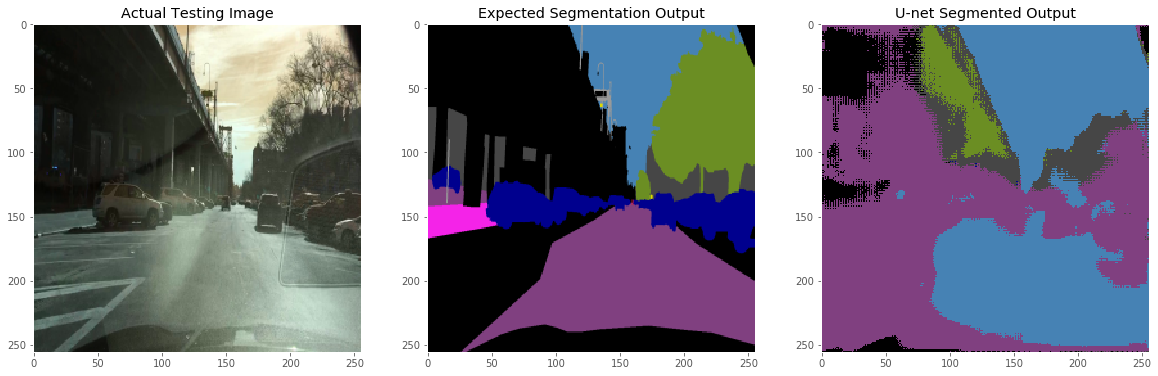

In [182]:
# Batch size = 1 
# Learning Rate = 0.01

ix = random.randint(0, len(preds_test))
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(X_test[ix])
ax1.title.set_text('Actual Testing Image')
ax1.grid(False)

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Expected Segmentation Output')
ax2.imshow(Y_test[ix])
ax2.grid(False)

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('U-net Segmented Output')
ax3.imshow(preds_testRGB[ix])
ax3.grid(False)

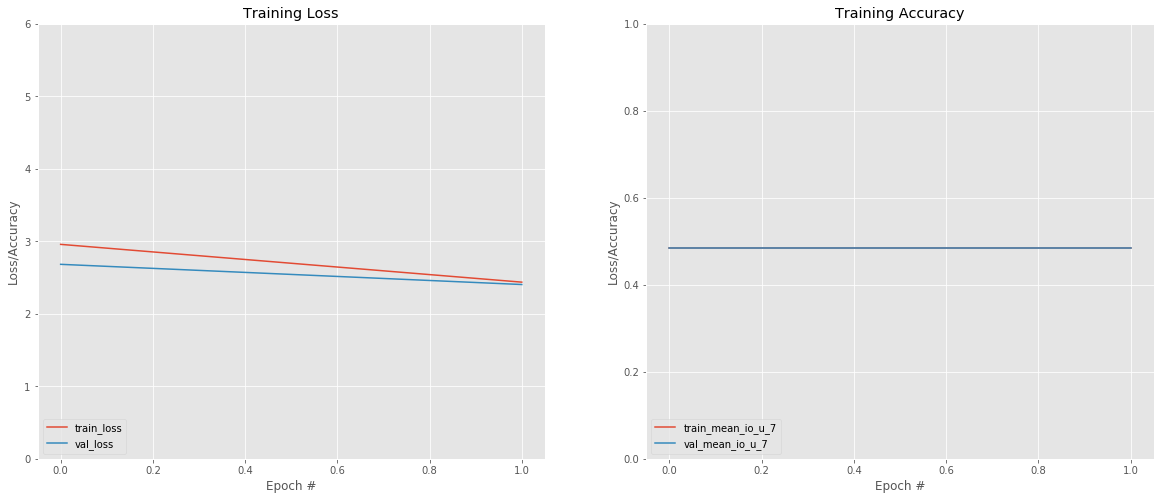

In [178]:
# Batch size = 1 
# Learning Rate = 0.01

N = len(results.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), results.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), results.history["val_loss"], label="val_loss")
plt.ylim(0, 6)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.show()

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), results.history["mean_io_u_7"], label="train_mean_io_u_7")
plt.plot(np.arange(0, N), results.history["val_mean_io_u_7"], label="val_mean_io_u_7")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

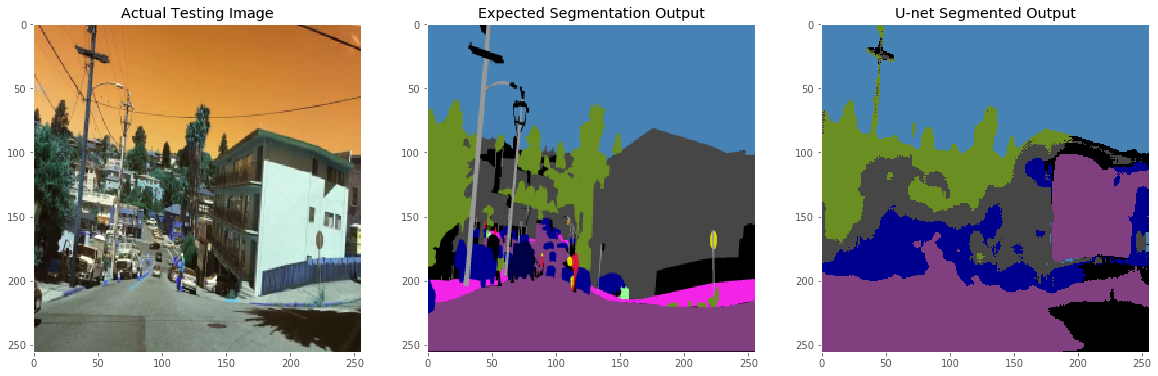

In [200]:
# Batch size = 1 
# Learning Rate = 0.05

ix = random.randint(0, len(preds_test))
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(X_test[ix])
ax1.title.set_text('Actual Testing Image')
ax1.grid(False)

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Expected Segmentation Output')
ax2.imshow(Y_test[ix])
ax2.grid(False)

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('U-net Segmented Output')
ax3.imshow(preds_testRGB[ix])
ax3.grid(False)

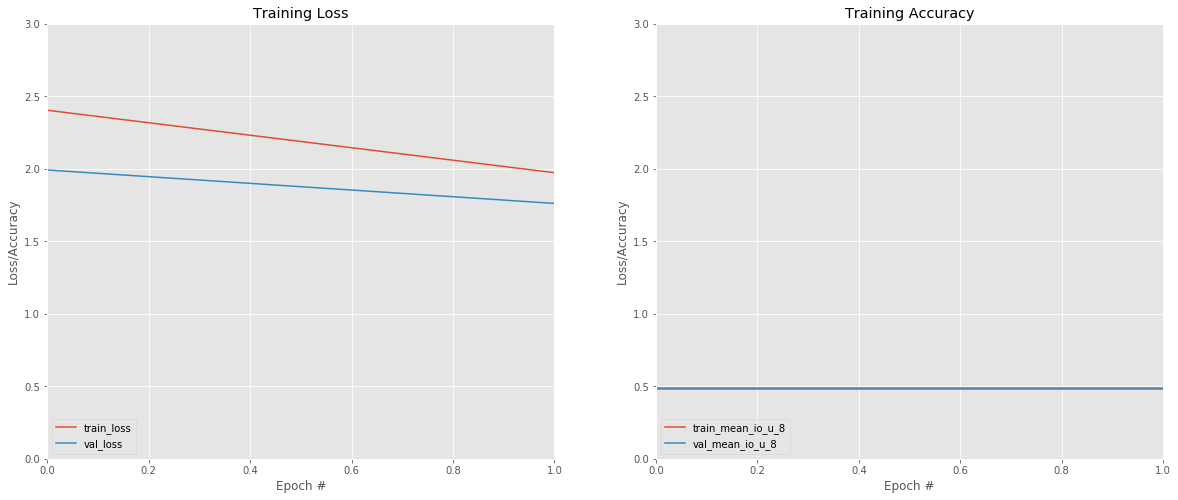

In [201]:
# Batch size = 1 
# Learning Rate = 0.05

N = len(results.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), results.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), results.history["val_loss"], label="val_loss")
plt.ylim(0, 3)
plt.xlim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.show()

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), results.history["mean_io_u_8"], label="train_mean_io_u_8")
plt.plot(np.arange(0, N), results.history["val_mean_io_u_8"], label="val_mean_io_u_8")
plt.ylim(0, 3)
plt.xlim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

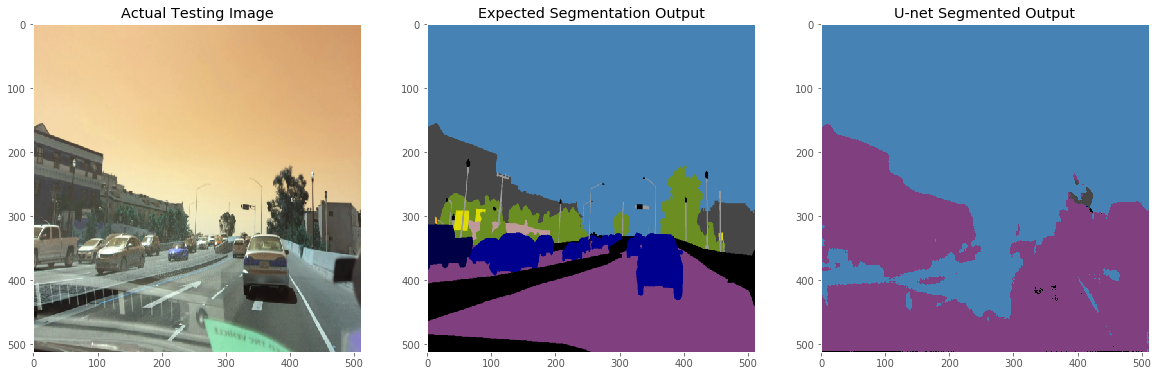

In [242]:
# Batch size = 1 
# Learning Rate = 0.01
# img size = 512 x 512 x 3

ix = random.randint(0, 10)
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(X_test[ix])
ax1.title.set_text('Actual Testing Image')
ax1.grid(False)

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Expected Segmentation Output')
ax2.imshow(Y_test[ix])
ax2.grid(False)

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('U-net Segmented Output')
ax3.imshow(preds_testRGB[ix])
ax3.grid(False)

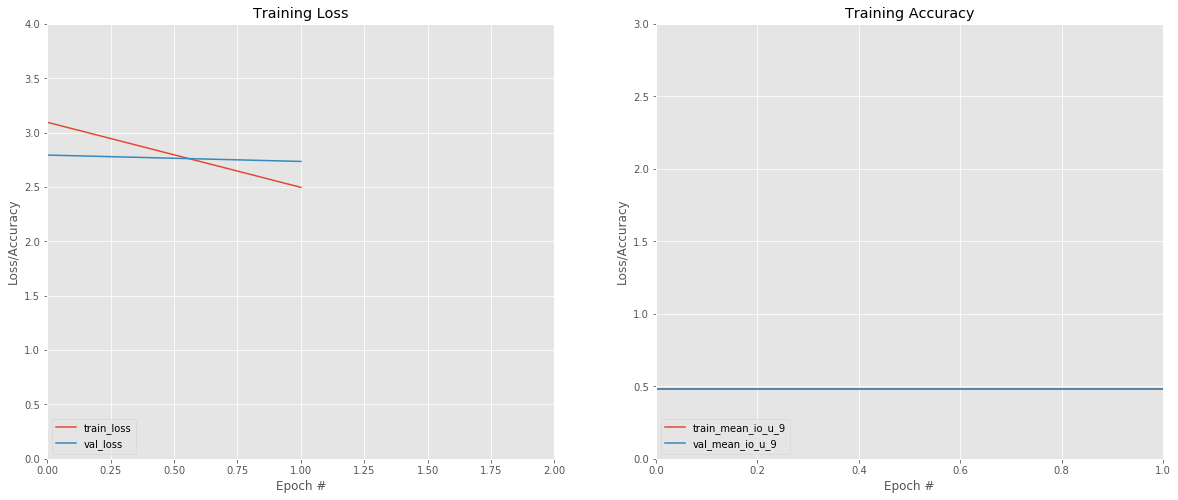

In [240]:
# Batch size = 1 
# Learning Rate = 0.01
# img size = 512 x 512 x 3

N = len(results.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), results.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), results.history["val_loss"], label="val_loss")
plt.ylim(0, 4)
plt.xlim(0, 2)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.show()

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), results.history["mean_io_u_9"], label="train_mean_io_u_9")
plt.plot(np.arange(0, N), results.history["val_mean_io_u_9"], label="val_mean_io_u_9")
plt.ylim(0, 3)
plt.xlim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()